In [18]:
%load_ext ipydex.displaytools
import sympy as sp
from sympy import sin, cos
import numpy as np
import scipy.integrate
import symbtools as st
import symbtools.modeltools as mt
import matplotlib.pyplot as plt
sp.init_printing()

The ipydex.displaytools extension is already loaded. To reload it, use:
  %reload_ext ipydex.displaytools


In [33]:
theta1, theta2 = theta = st.symb_vector('theta1:3')
dtheta1, dtheta2 = dtheta = st.time_deriv(theta, theta)
tau = sp.symbols('tau')
params = st.symb_vector('m1 l1 J1 mu1 m2 r2 J2 mu2')
st.make_global(params)

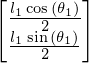

---


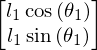

---


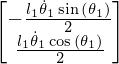

---


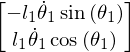

---


In [55]:
p0 = sp.Matrix([0, 0])
p1 = sp.Matrix([l1/2*cos(theta1), l1/2*sin(theta1)]) ##:
p2 = sp.Matrix([l1*cos(theta1), l1*sin(theta1)]) ##:
p3 = p2 + sp.Matrix([r2*cos(theta1+theta2), r2*sin(theta1+theta2)])
dp1 = st.time_deriv(p1, theta) ##:
dp2 = st.time_deriv(p2, theta) ##:

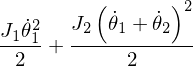

---


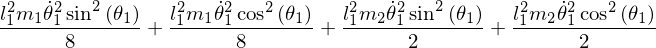

---


---


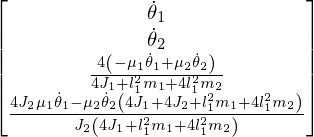

---


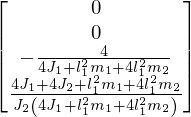

---


In [21]:
T_rot = J1 * dtheta1**2 / 2 + J2 * (dtheta1 + dtheta2)**2 / 2 ##:
T_trans = (m1 * dp1.T * dp1 / 2 + m2 * dp2.T * dp2 / 2)[0] ##:
T = T_rot + T_trans
V = 0 ##:
friction1 = dtheta1 * mu1
friction2 = dtheta2 * mu2

model = mt.generate_symbolic_model(T, V, theta, [0 - friction1, tau - friction2])
model.tau = [tau]
model.calc_state_eq()

f = model.f ##:
g = model.g ##:

In [135]:
m1_val = 0.1
m2_val = 1
l1_val = 0.5
r2_val = 0.2
J1_val = 1/12 * m1_val * l1_val**2
J2_val = 1/2 * m2_val * r2_val**2
mu1_val = 0.01
mu2_val = 0.001

param_subs = st.lzip(params, [m1_val, l1_val, J1_val, mu1_val, m2_val, r2_val, J2_val, mu2_val])

f_fun = st.expr_to_func(model.x, f.subs(param_subs))
g_fun = st.expr_to_func(model.x, g.subs(param_subs))

def tau_fun(t, x):
    return np.sin(2*np.pi*0.25*t)

def ode_fun(t, x):
    return f_fun(x[0], x[1], x[2], x[3]) + tau_fun(t, x) * g_fun(x[0], x[1], x[2], x[3])

x_init = np.array([0, 0, 0, 2])
tf = 10.0
dt = 1/30
ts = np.arange(0.0, tf, dt)
samples = len(ts)
ys = np.empty((samples, len(model.x)))
ys[0, :] = x_init

for i in range(samples - 1):
    result = scipy.integrate.solve_ivp(ode_fun, (ts[i], ts[i+1]), ys[i, :])
    ys[i+1, :] = result.y[:, -1]

In [130]:
from ipywidgets import FloatSlider, interact
import matplotlib.animation as animation
from IPython.display import HTML

def merge_options(custom_options, **default_options):
    merged_options = default_options
    merged_options.update(custom_options)
    return merged_options

class VisualiserElement:
    def __init__(self, points_fun, init_fun, update_fun, kwargs):
        self.points_fun = points_fun
        self.init_fun = init_fun
        self.update_fun = update_fun
        self.kwargs = kwargs
        self.drawables = []
        
class Visualiser:
    def __init__(self, variables, **axes_options):
        self.variables = variables
        self.elements = []
        self.axes_options = axes_options
        
    def create_default_axes(self):
        fig = plt.figure()
        ax = plt.axes(**merge_options(self.axes_options, aspect='equal', xlim=(-2.0, 2.0), ylim=(-2.0, 2.0)))
        ax.grid()
        
        return fig, ax
    
    def plot(self, variables_values, axes=None):
        assert len(self.variables) == len(variables_values), f"You need to pass as many variable values as this visualiser has variables. Required: {len(self.variables)}, Given: {len(variables_values)}"
        
        fig = None
        if axes is None:
            fig, axes = self.create_default_axes()
            plt.close()
            
        self.plot_init(variables_values, axes)
        self.plot_update(variables_values, axes)
        if fig is not None:
            display(fig)
            
    def plot_init(self, variables_values, axes):
        drawables = []
        for element in self.elements:
            element.drawables = element.init_fun(axes, element.points_fun(*variables_values), element.kwargs)
            drawables += element.drawables
            
        return drawables
    
    def plot_update(self, variables_values, axes):
        drawables = []
        for element in self.elements:
            element.drawables = element.update_fun(axes, element.drawables, element.points_fun(*variables_values), element.kwargs)
            drawables += element.drawables
        
        return drawables
            
    def interact(self, fig=None, axes=None, **kwargs):
        widget_dict = dict()
        
        for var in self.variables:
            var_str = repr(var)
            if var_str in kwargs:
                widget_dict[var_str] = kwargs[var_str]
            else:
                widget_dict[var_str] = F(-5.0, 5.0, 0.1, 0.0)
                
        if fig is None or axes is None:
            fig, axes = self.create_default_axes()
            plt.close()
        
        is_initialized = False
                
        def interact_fun(**kwargs):
            nonlocal is_initialized
            variables_values = [kwargs[repr(var_symbol)] for var_symbol in self.variables]
            
            if not is_initialized:
                self.plot_init(variables_values, axes)
                is_initialized = True
                
            self.plot_update(variables_values, axes)
            display(fig)
        
        interact(interact_fun, **widget_dict)
        
    def add_element(self, points, init_fun, update_fun, **kwargs):
        if not isinstance(points, sp.Matrix):
            if isinstance(points, list):
                points = st.col_stack(*points)
            else:
                raise Exception("'points' must be a SymPy matrix or a list of column vectors")
            
        points_fun = st.expr_to_func(self.variables, points, keep_shape=True)
        self.elements.append(VisualiserElement(points_fun, init_fun, update_fun, kwargs))
        
    def add_linkage(self, points, **kwargs):
        self.add_element(points, init_linkage, update_linkage, **kwargs)
        
    def add_polygon(self, points, **kwargs):
        self.add_element(points, init_polygon, update_polygon, **kwargs)
        
    def add_disk(self, points, **kwargs):
        self.add_element(points, init_disk, update_disk, **kwargs)
        
def init_linkage(ax, points, kwargs):
    return ax.plot(points[0, :], points[1, :], **merge_options(kwargs, marker='o', ls='-', lw=3))

def update_linkage(ax, drawables, points, kwargs):
    drawables[0].set_data(points)
    return drawables

def init_polygon(ax, points, kwargs):
    poly = plt.Polygon(points.T, **kwargs)
    ax.add_patch(poly)
    
    return [poly]

def update_polygon(ax, drawables, points, kwargs):
    poly = drawables[0]
    poly.set_xy(points.T)
    
    return drawables

def init_disk(ax, points, kwargs):
    assert points.shape == (2, 2)
    center_point = points[:, 0]
    border_point = points[:, 1]
    radius = np.sqrt(np.sum((border_point - center_point)**2))
    circle = plt.Circle(center_point, radius, **merge_options(kwargs, fill=False))
    line, = ax.plot(points[0, :], points[1, :], **merge_options(kwargs, color=circle.get_edgecolor()))
    
    ax.add_patch(circle)
    
    return [circle, line]
    
def update_disk(ax, drawables, points, kwargs):
    assert points.shape == (2, 2)
    center_point = points[:, 0]
    border_point = points[:, 1]
    
    circle = drawables[0]
    circle.set_center(center_point)
    radius = np.sqrt(np.sum((border_point - center_point)**2))
    circle.set_radius(radius)
    
    line = drawables[1]
    line.set_data(points[0, :], points[1, :])
    
    return drawables
    
def F(min, max, step, value):
    return FloatSlider(min=min, max=max, step=step, value=value)


class SimAnimation:
    def __init__(self, x_symb, t, x_sim, fig=None):
        self.x_symb = x_symb
        self.t = t
        self.x_sim = x_sim
        if fig is None:
            #TODO: Create default fig
            pass
        self.fig = fig
        self.axes = []
    
    def addAxes(self, content, ax=None, **kwargs):
        if ax is None:
            #TODO: Create default axes
            pass
        
        assert isinstance(content, Visualiser) or isinstance(content, sp.Expr) or isinstance(content, sp.Matrix) or isinstance(content, list)
        self.axes.append((ax, content))
        
    def display(self):
        init_drawables = []
        
        def anim_init():
            nonlocal init_drawables
            
            # If anim_init gets called multiple times (as is the case when blit=True), we need to remove
            # all remaining drawables before instantiating new ones
            while init_drawables:
                drawable = init_drawables.pop()
                drawable.remove()
            
            for (ax, content) in self.axes:
                if isinstance(content, Visualiser):
                    new_drawables = content.plot_init(np.zeros(len(content.variables)), ax)
                    init_drawables += new_drawables
                    
            return init_drawables
                    
        def anim_update(x):
            drawables = []
            
            for (ax, content) in self.axes:
                if isinstance(content, Visualiser):
                    vis_var_indices = self._find_variable_indices(content.variables)
                    vis_var_values = x[vis_var_indices]
                    
                    drawables += content.plot_update(vis_var_values, ax)
            
            return drawables
        
        anim = animation.FuncAnimation(self.fig, anim_update, init_func=anim_init, frames=self.x_sim, interval=1000*(self.t[-1] - self.t[0])/(len(self.t)-1), blit=True)
        display(HTML(anim.to_jshtml()))
        
    def _find_variable_indices(self, variables):
        assert all([var in self.x_symb for var in variables])

        indices = np.zeros(len(variables), dtype=int)
        for var_i, var in enumerate(variables):
            for x_i in range(len(self.x_symb)):
                if self.x_symb[x_i] == var:
                    indices[var_i] = x_i
                    break

        return indices

In [131]:
vis = Visualiser(theta, xlim=(-1, 1), ylim=(-1, 1))
vis.add_linkage([p0.subs(param_subs), p2.subs(param_subs)])
vis.add_disk([p2.subs(param_subs), p3.subs(param_subs)], color="red")

In [128]:
vis.interact()

interactive(children=(FloatSlider(value=0.0, description='theta1', max=5.0, min=-5.0), FloatSlider(value=0.0, …

In [136]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim([-1.0, 1.0])
ax.set_ylim([-1.0, 1.0])
ax.grid()
plt.close()

simanim = SimAnimation(model.x, ts, ys, fig=fig)
simanim.addAxes(vis, ax=ax)
simanim.display()

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(121)
ax.set_aspect('equal')
ax.set_xlim([-2.0, 2.0])
ax.set_ylim([-2.0, 2.0])
ax.grid()

ax2 = plt.subplot(122)
ax2.grid()
ax2.set_xlim([0, 10])
ax2.set_ylim([-1.5, 1.5])
graph_drawables = ax2.plot([], [])

data = np.zeros((3, 300))
ts = np.linspace(0, 10, 300, endpoint=False)

def anim_init():
    vis_drawables = vis.plot_init([0.0, 0.0, 0.0], ax)
    
    return vis_drawables + graph_drawables

def anim_update(i):
    t = ts[i]
    t1 = 2*np.pi*0.25*t
    t2 = 2*np.pi*0.5*t
    t3 = 2*np.pi*0.3333*t
    
    data[0, i] = t1
    data[1, i] = t2
    data[2, i] = t3
    
    vis_drawables = vis.plot_update([t1, t2, t3], ax)
    
    graph_drawables[0].set_data(ts[:i+1], np.sin(data[0,:i+1]))
    
    return vis_drawables + graph_drawables

plt.close()

ani = animation.FuncAnimation(fig, anim_update, init_func=anim_init, frames=300, interval=1000/30)
HTML(ani.to_jshtml())